In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import visualizer
import utils

import importlib

In [ ]:
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"
videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"
#videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

### Feed through the tracking pipeline

In [ ]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

In [ ]:
importlib.reload(tracker)

compute_segments = False
if compute_segments:
    final = tracker.segmentCells(frames, t)
else:
    final = t

print(final.head())

In [14]:
utils.saveDataFrame(final, videofile.split('.')[0] + '.csv')

### Use Visualizations

In [ ]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final, visualization="segments")

# Run Metrics

In [2]:
#prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"

#prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_corrected.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"

prediction = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted.csv"
groundtruth = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv"
videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Load as Pandas DataFrame
pred_src = utils.loadDataFrame(prediction)
gt_src = utils.loadDataFrame(groundtruth)


In [3]:
# Adhoc adjustment for testing
# pred_src = gt_src

### Preprocessing

In [4]:
import pandas as pd

def dropDuplicates(df):
      
    # Detect duplicate rows based on 'col1' and 'col2'
    #duplicate_rows = df[df.duplicated(subset=['frame', 'sperm'], keep='first')]
    result = df.drop_duplicates(subset=['frame', 'sperm'], keep='first')

    return result

def interpolateTracks(df):

    result = df.copy()

    for sperm in range(0, df['sperm'].max() + 1):
        sperm_frames = df[df['sperm'] == sperm]['frame'].values
        if len(sperm_frames) > 1:
            birth = np.amin(sperm_frames)
            death = np.amax(sperm_frames)


            # Find if the sperm exists for all frames
            if len(sperm_frames) != death - birth + 1:
                #print("Missing frames for sperm: ", sperm)
                #print("Birth: ", birth, ", Death: ", death)
                #print("Frames: ", sperm_frames)

                for j in range(birth, death + 1):
                    if j not in sperm_frames:
                 
                        # Find closest frame after the missing frame
                        before = np.amax(sperm_frames[np.where(sperm_frames < j)])
                        after = np.amin(sperm_frames[np.where(sperm_frames > j)])

                        # interpolate x and y
                        before_x = df[(df['sperm'] == sperm) & (df['frame'] == before)]['x'].values[0]
                        before_y = df[(df['sperm'] == sperm) & (df['frame'] == before)]['y'].values[0]
                        after_x = df[(df['sperm'] == sperm) & (df['frame'] == after)]['x'].values[0]
                        after_y = df[(df['sperm'] == sperm) & (df['frame'] == after)]['y'].values[0]

                        x = before_x + (after_x - before_x) * (j - before) / (after - before)
                        y = before_y + (after_y - before_y) * (j - before) / (after - before)

                        #print("Adding frame: ", j)
                        #gt = gt.append({'frame': j, 'sperm': sperm, 'x': x, 'y': y}, ignore_index=True)
                        result = pd.concat([result, pd.DataFrame([[j, sperm, x, y]], columns=['frame', 'sperm', 'x', 'y'])], ignore_index=True)

    return result

def filterSperm(df, epsilon=5.0):

    filter_list = []

    # Filter out sperm that are not moving
    for sperm in df['sperm'].unique():
        all_locs = df[df['sperm'] == sperm]
        # Determine the mean sperm location
        mean_loc = all_locs[['x', 'y']].mean()

        # If the furthest away is less than e, remove the sperm
        all_dists = all_locs[['x', 'y']].sub(mean_loc)
        all_dists = all_dists.pow(2)
        all_dists = all_dists.sum(axis=1)
        all_dists = all_dists.pow(0.5)
        if all_dists.max() < epsilon:
            filter_list.append(sperm)

    # Filter out sperm that are not moving
    df = df[~df['sperm'].isin(filter_list)]

    return df

gt_u = dropDuplicates(gt_src)
pred_u = dropDuplicates(pred_src)

print(len(gt_src), len(gt_u))
print(len(pred_src), len(pred_u))

gt = interpolateTracks(gt_u)
pred = interpolateTracks(pred_u)

print(len(gt_src))
print(len(gt))

pred_filter = filterSperm(pred)
gt_filter = filterSperm(gt)

print(len(pred['sperm'].unique()))
print(len(pred_filter['sperm'].unique()))

print(len(gt['sperm'].unique()))
print(len(gt_filter['sperm'].unique()))

13771 13766
15452 15452
13771
13867
99
75
81
65


In [4]:
# Visualize
visualizer.runVisualization(videofile, pred_src, visualization="flow")

(118, 3)
Video Finished.


In [11]:
visualizer.runVisualization(videofile, pred, visualization="flow")

(1258, 3)
Video Finished.


In [66]:
visualizer.runVisualization(videofile, pred_filter, visualization="flow")

(100, 3)
Video Finished.


In [50]:
visualizer.runVisualization(videofile, gt_src, visualization="flow")

(94, 3)
Video Finished.


In [52]:
visualizer.runVisualization(videofile, gt, visualization="flow")

(94, 3)
Video Finished.


In [24]:
visualizer.runVisualization(videofile, gt_filter, visualization="flow")

(109, 3)
Video Finished.


### Unlabeled Metrics

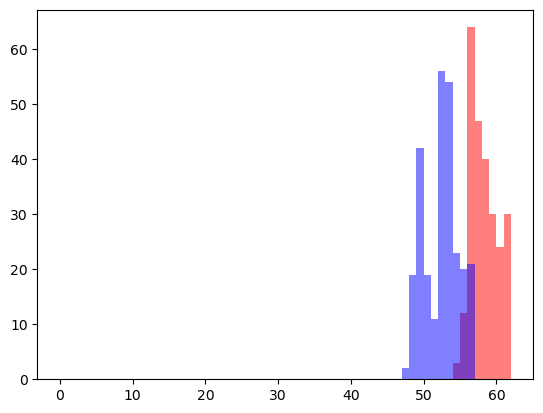

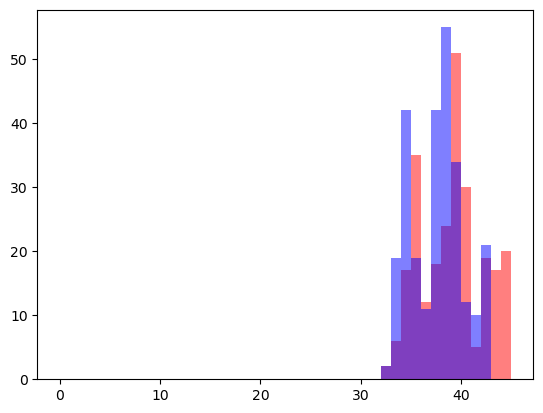

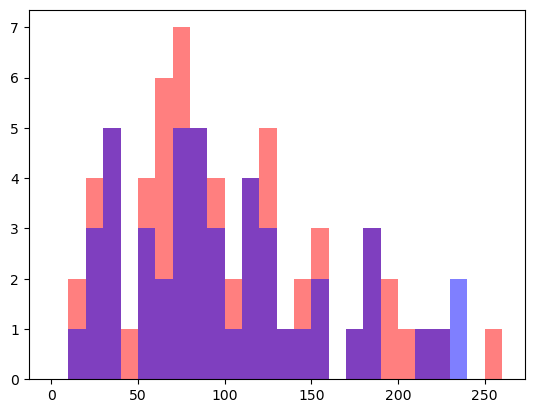

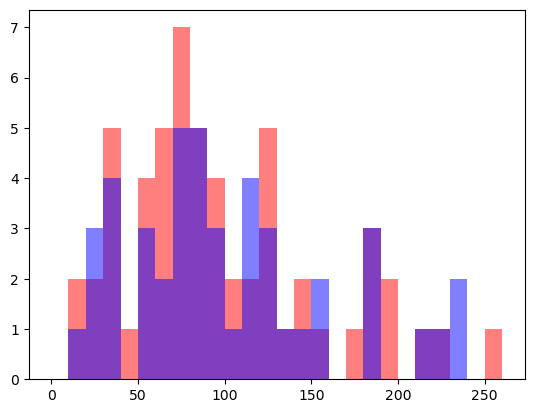

Sperm Per Frame Pred - Mean:  58.161048689138575 , Std:  2.260286437689016 , Normalized Mean:  0.9231912490339457 , Normalized Std:  0.035877562503000254
Sperm Per Frame GT - Mean:  51.93632958801498 , Std:  2.3543072352686694 , Normalized Mean:  0.8243861839367457 , Normalized Std:  0.037369956115375705
Frames Per Sperm Pred - Mean:  156.85858585858585 , Std:  91.73743935721329 , Normalized Mean:  0.5874853402943291 , Normalized Std:  0.34358591519555537
Frames Per Sperm GT - Mean:  171.19753086419752 , Std:  92.9273471361107 , Normalized Mean:  0.6411892541730244 , Normalized Std:  0.3480424986371187
Sperm Per Frame Filtered Pred - Mean:  38.9625468164794 , Std:  3.4854569274524927 Median: 39.0 , Normalized Mean:  0.8470118873147696 , Normalized Std:  0.07577080277070636
Sperm Per Frame Filtered GT - Mean:  37.161048689138575 , Std:  2.5936214659218852 Median: 37.0 , Normalized Mean:  0.8078488845464907 , Normalized Std:  0.056383075346127944
Frames Per Sperm Filtered Pred - Mean:  1

In [5]:
import pandas as pd

def spermPerFrame(df, return_summary=False):
    # Count occurrences of each sperm count in each frame
    frame_counts = {}
    max_sperm = df["sperm"].max()
    sperm_labels = list(range(max_sperm + 1))  # Generate labels from 0 to max_sperm

    for frame in df["frame"].unique():
        frame_counts[frame] = df[df["frame"] == frame]["sperm"].value_counts().reindex(sperm_labels).fillna(0)

    # Create a DataFrame for sperm counts per frame
    frame_summary = pd.DataFrame.from_dict(frame_counts, orient='index', columns=sperm_labels)
    frame_summary.index.name = "frame"
    frame_summary.reset_index(inplace=True)

    # Add a column for total sperms observed in each frame
    frame_summary["TotalSperms"] = frame_summary[sperm_labels].sum(axis=1)

    # Extract ["TotalSperms"] as numpy array
    array = frame_summary["TotalSperms"].values

    if return_summary:
        return array, frame_summary
    else:
        return array

def framesPerSperm(df, return_summary=False):
    sperm_counts = {}
    max_frame = df["frame"].max()
    frame_labels = list(range(max_frame + 1)) # Generate labels from 0 to max_frame

    for sperm in df["sperm"].unique():
        sperm_counts[sperm] = df[df["sperm"] == sperm]["frame"].value_counts().reindex(frame_labels).fillna(0)

    # Create a DataFrame for frame counts per sperm
    sperm_summary = pd.DataFrame.from_dict(sperm_counts, orient='index', columns=frame_labels)
    sperm_summary.index.name = "sperm"
    sperm_summary.reset_index(inplace=True)

    # Add a column for total sperms observed in each frame
    sperm_summary["TotalFrames"] = sperm_summary[frame_labels].sum(axis=1)

    # Remove sperms that are not observed in any frame
    sperm_summary = sperm_summary[sperm_summary["TotalFrames"] > 0]

    # Extract ["TotalFrames"] as numpy array
    array = sperm_summary["TotalFrames"].values

    if return_summary:
        return array, sperm_summary
    else:
        return array


pred_spf = spermPerFrame(pred)
gt_spf = spermPerFrame(gt)
pred_filter_spf = spermPerFrame(pred_filter)
gt_filter_spf = spermPerFrame(gt_filter)

#print(pred_frames)
#print(gt_frames)

pred_fps = framesPerSperm(pred)
gt_fps = framesPerSperm(gt)
pred_filter_fps = framesPerSperm(pred_filter)
gt_filter_fps = framesPerSperm(gt_filter)

#print(pred_sperm)
#print(gt_sperm)

max_sperm = int(max(max(pred_spf), max(gt_spf)))
max_filter_sperm = int(max(max(pred_filter_spf), max(gt_filter_spf)))

plt.hist(pred_spf, bins=range(0, max_sperm, 1), alpha=0.5, color='red', label='Predicted')
plt.hist(gt_spf, bins=range(0, max_sperm, 1), alpha=0.5, color='blue',label='Ground Truth')
plt.show()

plt.hist(pred_filter_spf, bins=range(0, max_filter_sperm, 1), alpha=0.5, color='red', label='Predicted')
plt.hist(gt_filter_spf, bins=range(0, max_filter_sperm, 1), alpha=0.5, color='blue',label='Ground Truth')
plt.show()

max_frames = int(max(max(pred_fps), max(gt_fps)))
max_filter_frames = int(max(max(pred_filter_fps), max(gt_filter_fps)))

plt.hist(pred_fps, bins=range(0, max_frames, 10), alpha=0.5, color='red', label='Predicted')
plt.hist(gt_fps, bins=range(0, max_frames, 10), alpha=0.5, color='blue',label='Ground Truth')
plt.show()

plt.hist(pred_filter_fps, bins=range(0, max_filter_frames, 10), alpha=0.5, color='red', label='Predicted')
plt.hist(gt_filter_fps, bins=range(0, max_filter_frames, 10), alpha=0.5, color='blue',label='Ground Truth')
plt.show()


print("Sperm Per Frame Pred - Mean: ", np.mean(pred_spf), ", Std: ", np.std(pred_spf), ", Normalized Mean: ", np.mean(pred_spf)/max_sperm, ", Normalized Std: ", np.std(pred_spf)/max_sperm)
print("Sperm Per Frame GT - Mean: ", np.mean(gt_spf), ", Std: ", np.std(gt_spf), ", Normalized Mean: ", np.mean(gt_spf)/max_sperm, ", Normalized Std: ", np.std(gt_spf)/max_sperm)
print("Frames Per Sperm Pred - Mean: ", np.mean(pred_fps), ", Std: ", np.std(pred_fps), ", Normalized Mean: ", np.mean(pred_fps)/max_frames, ", Normalized Std: ", np.std(pred_fps)/max_frames)
print("Frames Per Sperm GT - Mean: ", np.mean(gt_fps), ", Std: ", np.std(gt_fps), ", Normalized Mean: ", np.mean(gt_fps)/max_frames, ", Normalized Std: ", np.std(gt_fps)/max_frames)

print("Sperm Per Frame Filtered Pred - Mean: ", np.mean(pred_filter_spf), ", Std: ", np.std(pred_filter_spf), "Median:", np.median(pred_filter_spf), ", Normalized Mean: ", np.mean(pred_filter_spf)/max_filter_sperm, ", Normalized Std: ", np.std(pred_filter_spf)/max_filter_sperm)
print("Sperm Per Frame Filtered GT - Mean: ", np.mean(gt_filter_spf), ", Std: ", np.std(gt_filter_spf), "Median:", np.median(gt_filter_spf), ", Normalized Mean: ", np.mean(gt_filter_spf)/max_filter_sperm, ", Normalized Std: ", np.std(gt_filter_spf)/max_filter_sperm)
print("Frames Per Sperm Filtered Pred - Mean: ", np.mean(pred_filter_fps), ", Std: ", np.std(pred_filter_fps), "Median:", np.median(pred_filter_fps), ", Normalized Mean: ", np.mean(pred_filter_fps)/max_filter_frames, ", Normalized Std: ", np.std(pred_filter_fps)/max_filter_frames)
print("Frames Per Sperm Filtered GT - Mean: ", np.mean(gt_filter_fps), ", Std: ", np.std(gt_filter_fps), "Median:", np.median(gt_filter_fps), ", Normalized Mean: ", np.mean(gt_filter_fps)/max_filter_frames, ", Normalized Std: ", np.std(gt_filter_fps)/max_filter_frames)


### Labeled Metrics

In [6]:
# Create track data needed for calculation (Label, Birth Frame, Death Frame, 0 (no parent))

def makeTrackData(df):
    tracks = []

    for s in range(0, df['sperm'].max() + 1):
        cur_frames = df[df['sperm'] == s]['frame'].values
        if len(cur_frames) > 0:
            cur_birth = np.amin(cur_frames)
            cur_death = np.amax(cur_frames)
            cur_parent = 0
            cur_track = [s, cur_birth, cur_death, cur_parent]
            tracks.append(cur_track)

    return np.array(tracks)

pred_tracks = makeTrackData(pred)
gt_tracks = makeTrackData(gt)
pred_filter_tracks = makeTrackData(pred_filter)
gt_filter_tracks = makeTrackData(gt_filter)

#ref_tracks = []

#for s in range(0, gt['sperm'].max() + 1):
#    cur_frames = gt[gt['sperm'] == s]['frame'].values
#    if len(cur_frames) > 0:
#        cur_birth = np.amin(cur_frames)
#        cur_death = np.amax(cur_frames)
#        cur_parent = 0
#        cur_track = [s, cur_birth, cur_death, cur_parent]
#        ref_tracks.append(cur_track)

#ref_tracks = np.array(ref_tracks)

#comp_tracks = []

#for s in range(0, pred['sperm'].max() + 1):
#    cur_frames = pred[pred['sperm'] == s]['frame'].values
#    if len(cur_frames) > 0:
#        cur_birth = np.amin(cur_frames)
#        cur_death = np.amax(cur_frames)
#        cur_parent = 0
#        cur_track = [s, cur_birth, cur_death, cur_parent]
#        comp_tracks.append(cur_track)

#comp_tracks = np.array(comp_tracks)

In [7]:
from  scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist


def makeTrajectoryData(pred,gt,cutoff=10):

    # Use Hungarian Algorithm to find best track matches between pred and gt in each frame
    labels_ref = []
    labels_comp = []
    mapped_ref = []
    mapped_comp = []

    # For each frame
    for f in range(0, pred['frame'].max() + 1):

        mapped_ref_frame = []
        mapped_comp_frame = []

        # Get the labels in the frame
        ref_data = gt[gt['frame'] == f][['sperm','x','y']].values
        comp_data = pred[pred['frame'] == f][['sperm','x','y']].values

        labels_ref_frame = ref_data[:,0].astype(int)
        labels_comp_frame = comp_data[:,0].astype(int)

        ref_centroids = ref_data[:,1:]
        comp_centroids = comp_data[:,1:]

        #labels_ref_frame = gt[gt['frame'] == f]['sperm'].values
        #labels_comp_frame = pred[pred['frame'] == f]['sperm'].values
        #print(labels_ref_frame.dtype, labels_ref_frame2.dtype)

        # Get the centroids in the frame
        #ref_centroids = gt[gt['frame'] == f][['x', 'y']].values
        #comp_centroids = pred[pred['frame'] == f][['x', 'y']].values

        # Compute the distance matrix
        dist_matrix = cdist(ref_centroids, comp_centroids)

        #print(dist_matrix.shape)

        #import matplotlib.pyplot as plt
        #plt.imshow(dist_matrix);plt.show()
        #print(np.amin(dist_matrix))

        # Use Hungarian Algorithm to find best matches
        row_ind, col_ind = linear_sum_assignment(dist_matrix)

        # Check for matches that are too far apart
        for r, c in zip(row_ind, col_ind):
            #print(dist_matrix[r, c])
            if dist_matrix[r, c] > cutoff:
                row_ind = np.delete(row_ind, np.where(row_ind == r))
                col_ind = np.delete(col_ind, np.where(col_ind == c))

        if (len(row_ind) != len(np.unique(row_ind))):
            print("row issue!")
            print(row_ind.shape,np.unique(row_ind).shape)

        if (len(col_ind) != len(np.unique(col_ind))):
            print("col issue!")
            print(col_ind.shape,np.unique(col_ind).shape)

        if len(labels_ref_frame) != len(np.unique(labels_ref_frame)):
            print("labels_ref issue!")
        
        if len(labels_comp_frame) != len(np.unique(labels_comp_frame)):
            print("labels_comp issue!")

        #for r, c in zip(row_ind, col_ind):
        #    print(r,c)

        # Save the matches
        for r, c in zip(row_ind, col_ind):
            mapped_ref_frame.append(labels_ref_frame[r])
            mapped_comp_frame.append(labels_comp_frame[c])

            #labels_ref_frame.append(ref_labels[r])
            #labels_comp_frame.append(comp_labels[c])
            #mapped_ref_frame.append(gt[(gt['frame'] == f) & (gt['sperm'] == ref_labels[r])]['sperm'].values[0])
            #mapped_comp_frame.append(pred[(pred['frame'] == f) & (pred['sperm'] == comp_labels[c])]['sperm'].values[0])

        labels_ref.append(labels_ref_frame)
        labels_comp.append(labels_comp_frame)
        mapped_ref.append(mapped_ref_frame)
        mapped_comp.append(mapped_comp_frame)

    traj = {}
    traj['labels_ref'] = labels_ref
    traj['labels_comp'] = labels_comp
    traj['mapped_ref'] = mapped_ref
    traj['mapped_comp'] = mapped_comp

    #print(labels_ref)
    #print(labels_comp)
    #print(mapped_ref)
    #print(mapped_comp)

    return traj

traj = makeTrajectoryData(pred,gt)
traj_filter = makeTrajectoryData(pred_filter,gt_filter)

In [8]:
from ctc_metrics.utils.representations import merge_tracks, count_acyclic_graph_correction_operations

def appendMergedTrajectory(ref_tracks, comp_tracks, traj):

    new_tracks, new_labels, new_mapped = merge_tracks(
        ref_tracks, traj["labels_ref"], traj["mapped_ref"])
    traj["ref_tracks_merged"] = new_tracks
    traj["labels_ref_merged"] = new_labels
    traj["mapped_ref_merged"] = new_mapped
    new_tracks, new_labels, new_mapped = merge_tracks(
        comp_tracks, traj["labels_comp"], traj["mapped_comp"])
    traj["comp_tracks_merged"] = new_tracks
    traj["labels_comp_merged"] = new_labels
    traj["mapped_comp_merged"] = new_mapped

    return traj

traj = appendMergedTrajectory(gt_tracks, pred_tracks, traj)
traj_filter = appendMergedTrajectory(gt_filter_tracks, pred_filter_tracks, traj_filter)


In [9]:
from ctc_metrics.utils.representations import count_acyclic_graph_correction_operations
from ctc_metrics.metrics import (
    valid, det, seg, tra, ct, tf, bc, cca, mota, hota, idf1, chota, mtml, faf,
    op_ctb, op_csb, bio, op_clb, lnk
)

def computeMetrics(ref_tracks, comp_tracks, traj):

    graph_operations = \
                count_acyclic_graph_correction_operations(
                    ref_tracks, comp_tracks,
                    traj["labels_ref"], traj["labels_comp"],
                    traj["mapped_ref"], traj["mapped_comp"]
                )

    #print(graph_operations)

    results = {}
    results["DET"] = det(**graph_operations)
    _tra, _aogm, _aogm0 = tra(**graph_operations)
    results["TRA"] = _tra
    results["AOGM"] = _aogm
    results["AOGM_0"] = _aogm0
    for key in ("NS", "FN", "FP", "ED", "EA", "EC"):
        results[f"AOGM_{key}"] = graph_operations[key]

    results["LNK"] = lnk(**graph_operations)

    results["CT"] = ct(
                comp_tracks, ref_tracks,
                traj["labels_ref"], traj["mapped_ref"], traj["mapped_comp"])

    results["TF"] = tf(
        ref_tracks,
        traj["labels_ref"], traj["mapped_ref"], traj["mapped_comp"])


    results.update(mota(
        traj["labels_ref_merged"], traj["labels_comp_merged"],
        traj["mapped_ref_merged"], traj["mapped_comp_merged"]))

    results.update(hota(
        traj["labels_ref_merged"], traj["labels_comp_merged"],
        traj["mapped_ref_merged"], traj["mapped_comp_merged"]))

    results.update(idf1(
        traj["labels_ref_merged"], traj["labels_comp_merged"],
        traj["mapped_ref_merged"], traj["mapped_comp_merged"]))
    
    return results

results = computeMetrics(gt_tracks, pred_tracks, traj)
results_filter = computeMetrics(gt_filter_tracks, pred_filter_tracks, traj_filter)


In [10]:
for key,val in results.items():
    print(key, val)

DET 0.9673108819499532
TRA 0.7906889908314454
AOGM 33353.5
AOGM_0 159349.0
AOGM_NS 0
AOGM_FN 261
AOGM_FP 1923
AOGM_ED 10630
AOGM_EA 12127
AOGM_EC 0
LNK 0.0
CT 0.3
TF 0.8405952805021286
MOTA 0.840412490084373
TP 13606
FP 1923
FN 261
IDSW 29
MULTI-ASSIGNMENTS 0
Precision 0.8761671710992337
Recall 0.9811783370592053
HOTA 0.8558014437045894
IDF1 0.8393659001224656
IDP 0.7944490952411617
IDR 0.8896661137953414
IDTP 12337.0
IDFP 3192.0
IDFN 1530.0


In [11]:
for key,val in results_filter.items():
    print(key, val)

DET 0.9235335617818988
TRA 0.7595203740170431
AOGM 27416.0
AOGM_0 114005.5
AOGM_NS 0
AOGM_FN 646
AOGM_FP 1127
AOGM_ED 7079
AOGM_EA 8500
AOGM_EC 0
LNK 0.0
CT 0.2
TF 0.8035917162824191
MOTA 0.8186857488409595
TP 9276
FP 1127
FN 646
IDSW 26
MULTI-ASSIGNMENTS 0
Precision 0.8916658656156878
Recall 0.9348921588389437
HOTA 0.8194562362293802
IDF1 0.7948831488314884
IDP 0.7765067768912813
IDR 0.8141503729086877
IDTP 8078.0
IDFP 2325.0
IDFN 1844.0


In [14]:
from math import sqrt

def averagePathVelocity(data, fps=9, pixel_size=0.26, win_size=5):
    '''Calculate the average path velocity (VAP) over all frames

    Parameters:
    data (pd.DataFrame): DataFrame containing sperm tracking data with columns 'sperm', 'frame', 'x', and 'y'.
    fps (int): Frames per second, default is 30.
    pixel_size (float): Size of one pixel in micrometers (or any other unit), default is 0.26.
    win_size (int): Size of the window in micrometers (or any other unit), default is 1 aka calculates
    curvilinear velocity (VCL). Adjust window_size accordingly for VAP.
    Returns the pd.DataFrame: DataFrame with an additional column 'VAP' containing the average speed of each sperm cell.
    '''

    # Get unique sperm IDs
    sperm_ids = data['sperm'].unique()

    # Iterate over each sperm ID
    for sperm_id in sperm_ids:
        # Filter the dataframe for the current sperm
        sperm = data[data['sperm'] == sperm_id]

        # Sort the dataframe by frame
        sperm = sperm.sort_values(by='frame')

        # Set distance iteration based on window size
        distance_iteration = len(sperm) - win_size

        # Calculate the total distance traveled by the sperm
        total_distance = 0
        for j in range(1, distance_iteration):
            start = (sperm['x'].iloc[j - 1], sperm['y'].iloc[j - 1])
            end = (sperm['x'].iloc[j], sperm['y'].iloc[j])
            # Calculate the distance in pixels
            distance_pixels = sqrt((end[1] - start[1]) ** 2 + (end[0] - start[0]) ** 2)

            # Add total distance
            total_distance += distance_pixels

        # Calculate the average speed in real-world units per second
        if distance_iteration > 0:
            average_speed = total_distance * (fps / distance_iteration) * pixel_size
        else:
            average_speed = 0

        # Add the average speed to the dataframe
        data.loc[data['sperm'] == sperm_id, 'VAP'] = average_speed

    return data



def curvilinearVelocity(data, fps=9, pixel_size = 0.26):
    '''Calculate the average path velocity (VAP) over all frames

    Parameters:
    data (pd.DataFrame): DataFrame containing sperm tracking data with columns 'sperm', 'frame', 'x', and 'y'.
    fps (int): Frames per second, default is 30.
    pixel_size (float): Size of one pixel in micrometers (or any other unit), default is 0.26.
    win_size (int): Size of the window in micrometers (or any other unit), default is 1 aka calculates
    curvilinear velocity (VCL). Ajust window_size accordingly for VAP.
    Returns the pd.DataFrame: DataFrame with an additional column 'VAP' containing the average speed of each sperm cell.
    '''

    # Get unique sperm IDs
    sperm_ids = data['sperm'].unique()

    # Iterate over each sperm ID
    for sperm_id in sperm_ids:
        # Filter the dataframe for the current sperm
        sperm = data[data['sperm'] == sperm_id]

        # Sort the dataframe by frame
        sperm = sperm.sort_values(by='frame')

        # Get distance iteration
        distance_iteration = len(sperm) - 1

        # Calculate the total distance traveled by the sperm
        total_distance = 0
        for j in range(1, distance_iteration):
            start = (sperm['x'].iloc[j - 1], sperm['y'].iloc[j - 1])
            end = (sperm['x'].iloc[j], sperm['y'].iloc[j])
            # Calculate the distance in pixels
            distance_pixels = sqrt((end[1] - start[1]) ** 2 + (end[0] - start[0]) ** 2)

            # Add total distance
            total_distance += distance_pixels

        # Calculate the average speed in real-world units per second
        if distance_iteration > 0:
            average_speed = total_distance * (fps / distance_iteration) * pixel_size
        else:
            average_speed = 0

        # Add the average speed to the dataframe
        data.loc[data['sperm'] == sperm_id, 'VCL'] = average_speed

    return data


def straightLineVelocity(data, fps=9, pixel_size=0.26):
    '''Calculate the straight-line velocity (VSL) over all frames

     Parameters:
     data (pd.DataFrame): DataFrame containing sperm tracking data with columns 'sperm', 'frame', 'x', and 'y'.
     fps (int): Frames per second, default is 30.
     pixel_size (float): Size of one pixel in micrometers (or any other unit), default is 0.26.

     Returns:
     pd.DataFrame: DataFrame with an additional column 'VSL' containing the straight-line velocity of each sperm cell.
     '''

    # Get unique sperm IDs
    sperm_ids = data['sperm'].unique()

    # Iterate over each sperm ID
    for sperm_id in sperm_ids:
        # Filter the dataframe for the current sperm
        sperm = data[data['sperm'] == sperm_id]

        # Sort the dataframe by frame
        sperm = sperm.sort_values(by='frame')

        # Check if there are at least two points to calculate velocity
        if len(sperm) > 1:
            # Get the first and last points
            start = (sperm['x'].iloc[0], sperm['y'].iloc[0])
            end = (sperm['x'].iloc[-1], sperm['y'].iloc[-1])

            # Calculate the straight-line distance in pixels
            distance_pixels = np.sqrt((end[1] - start[1]) ** 2 + (end[0] - start[0]) ** 2)

            # Calculate the time interval in seconds
            time_interval = (sperm['frame'].iloc[-1] - sperm['frame'].iloc[0]) / fps

            # Calculate the straight-line velocity in real-world units per second
            if time_interval > 0:
                average_velocity = (distance_pixels * pixel_size) / time_interval
            else:
                average_velocity = 0

            # Add the average velocity to the dataframe
            data.loc[data['sperm'] == sperm_id, 'VSL'] = average_velocity
        else:
            # If there's only one point, velocity cannot be calculated
            data.loc[data['sperm'] == sperm_id, 'VSL'] = np.nan

    return data

In [15]:
# Get all three stats
gt = straightLineVelocity(gt)
gt = curvilinearVelocity(gt)
gt = averagePathVelocity(gt)
pred = straightLineVelocity(pred)
pred = curvilinearVelocity(pred)
pred = averagePathVelocity(pred)

gt_filter = straightLineVelocity(gt_filter)
gt_filter = curvilinearVelocity(gt_filter)
gt_filter = averagePathVelocity(gt_filter)
pred_filter = straightLineVelocity(pred_filter)
pred_filter = curvilinearVelocity(pred_filter)
pred_filter = averagePathVelocity(pred_filter)

C:\Users\hartda23\AppData\Local\Temp\ipykernel_13840\2011471450.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['sperm'] == sperm_id, 'VSL'] = average_velocity
C:\Users\hartda23\AppData\Local\Temp\ipykernel_13840\2011471450.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['sperm'] == sperm_id, 'VCL'] = average_speed
C:\Users\hartda23\AppData\Local\Temp\ipykernel_13840\2011471450.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


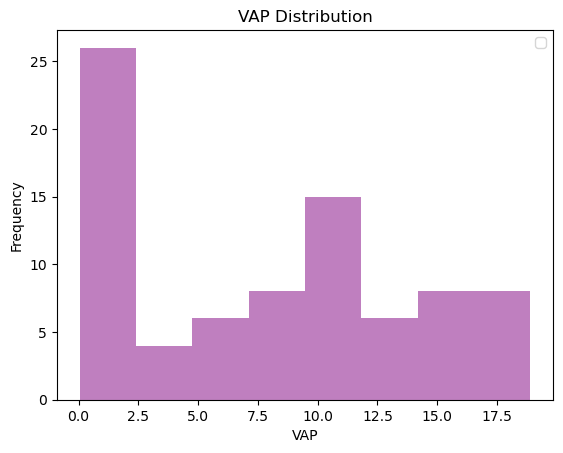

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


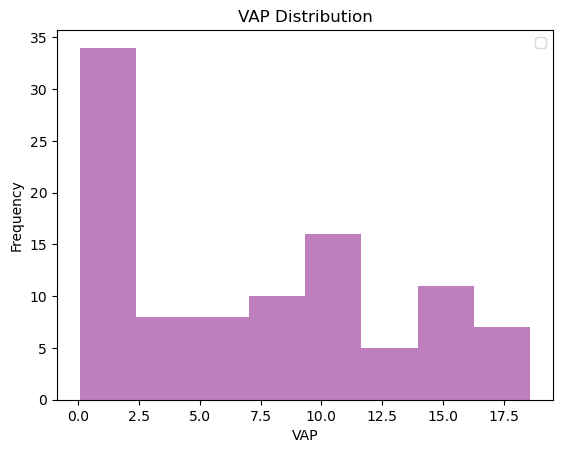

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


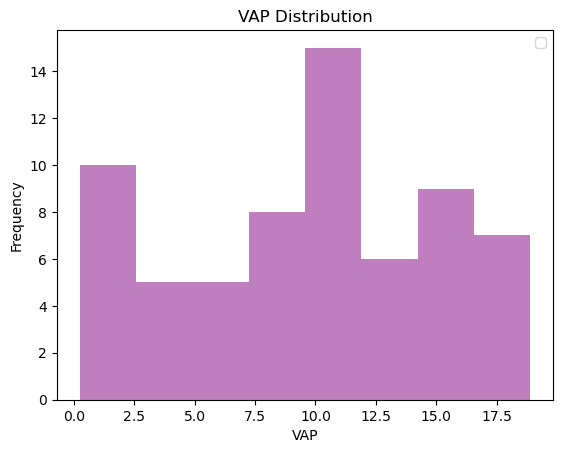

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


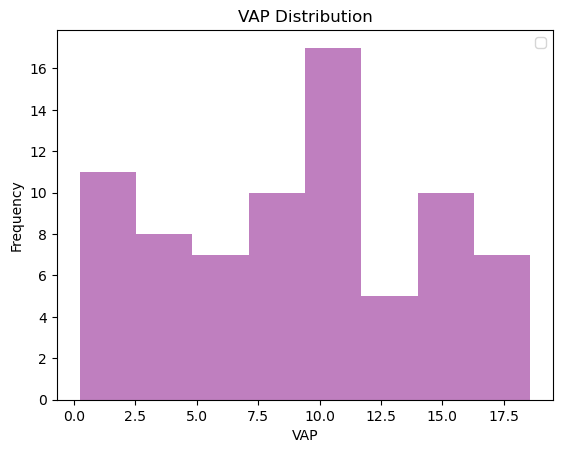

In [25]:
import matplotlib.pyplot as plt

# Generate historgrams for VSL, VCL, and VAP
def plotStat(data,stat="VAP"):

    # Get unique sperm
    sperm_ids = data['sperm'].unique()

    # Get first stat values for each sperm id
    first_values = data.groupby('sperm').first()[stat]

    plt.hist(first_values, bins='auto', alpha=0.5, color='purple')
    plt.xlabel(stat)
    plt.ylabel('Frequency')
    plt.title(f'{stat} Distribution')
    plt.legend()
    plt.show()

plotStat(gt,stat="VAP")
plotStat(pred,stat="VAP")
plotStat(gt_filter,stat="VAP")
plotStat(pred_filter,stat="VAP")